# Project name: Talk to your document using RAG

### Objective: 

Most of the scenario there should a need to read lenghly blogs, articles and etc but not having enough time or lack of interest makes us not readable. Such scenario RAG can be used to interact with data and retrieve answers. This project is one such application.

# Retrieval agumented generation (RAG) intro:

Retrieval-augmented generation (“RAG”) models combine the powers of pretrained dense retrieval (DPR) and sequence-to-sequence models. 

RAG models retrieve documents, pass them to a seq2seq model, then marginalize to generate outputs. 

The retriever and seq2seq modules are initialized from pretrained models, and fine-tuned jointly, allowing both retrieval and generation to adapt to downstream tasks.

### RAG workflow:
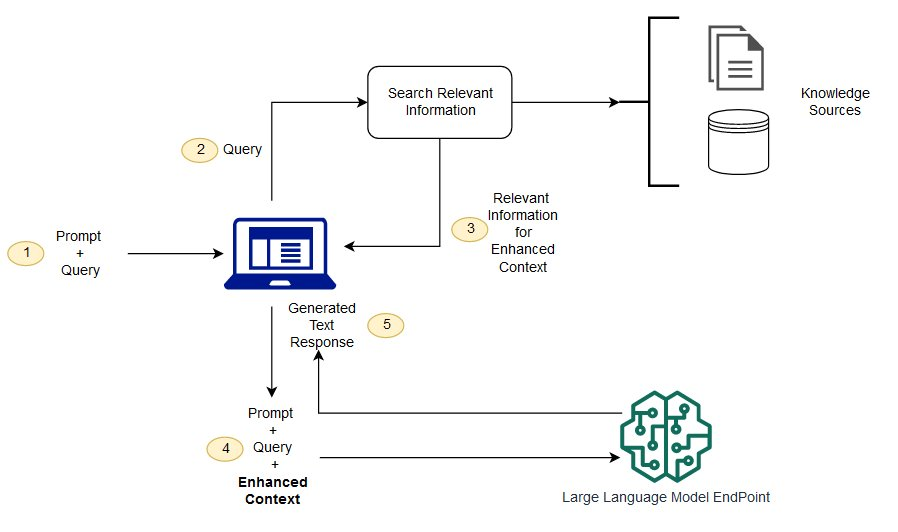


# Project outline:

### 1. Datasource load and text splitting
### 2. Vector embedding-Transform to vector representation
### 3. Vectore database-Store vector embedding in database for easy retrieval
### 4. LLM and RAG model initialization and conversation.

In [60]:
import transformers
import langchain
import torch
import pypdf
from langchain.vectorstores import FAISS

### 1. Datasource load and text splitting: 

In [61]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

document=PyPDFLoader("/kaggle/input/mahadev-resume/Mahadev_resume_latest.pdf")
documents=document.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=0)
chunks=text_splitter.split_documents(documents)

### 2. Vector embedding-Transform to vector representation:


In [62]:
from langchain.embeddings import HuggingFaceEmbeddings

modelPath = "/kaggle/input/sentence-transformers"
model_kwargs = {'device':'cpu'}
encode_kwargs = {'normalize_embeddings':False}
embeddings = HuggingFaceEmbeddings(model_name = modelPath,  model_kwargs = model_kwargs, encode_kwargs=encode_kwargs)

### 3. Vectore database-Store vector embedding in database for easy retrieval:


In [63]:
from langchain.vectorstores import FAISS

db = FAISS.from_documents(chunks, embeddings)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

### 4. LLM and RAG model initialization and conversation:

In [64]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from langchain import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA 

# google-flan-T5-large(text to text generation) model initialization:
tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-large')
model = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-large')

pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer)
llm = HuggingFacePipeline(pipeline = pipe, model_kwargs={"temperature": 1, "max_length": 512})

# creating prompt template which will be input instruction to LLM.
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.
{context}
Question: {question}
Answer in Italian:"""
QA_CHAIN_PROMPT = PromptTemplate(template=template, input_variables=['context','question'])

# Retreival model retrieves similar vector representation from embedding vector database and pass it to LLM along with prompt template. LLM draws conclusion based on data provided by RAG.
qa_chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=db.as_retriever(), chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}) 
question= "Where does a person lives as per resume?"
result = qa_chain ({ "query" : question}) 
print(result["result"])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

MSR Green city, Whitefield, Bengaluru – 560066


# Tested prompts with good completions:
question= "What is the person name mentioned in resume?"

question= "Where does a person lives as per resume?"

question= "How many years of experience does a person is having?"

question= "Name any 3 soft skills of person?"

question= "Name potential skills of person relevant to datascience and artificial intelligence field?"

question= "Is person experienced or fresher?"

question= "Does a person having any certifications related to Artificial intelligence. If yes, what are those certificates?"

question= "Does a candidate is having understanding on mathematics. If yes, what are concepts?"